# Measuring Similarity; Avoiding Changepoints

This notebook looks at measuring time series similarity with a single measure. In the presence of structural breaks statistical estimators which could be used to measure time series similarity become inconsistent. An example of this is when data is generated according to some parametric model where the parameters are piecewise constant. Given a very large panel of time series, particularly when forecasting is the goal, an analyst's work-flow might look like this: 

1. Screen the panel for groups of similar time series
2. Within each group look for possible changepoints
3. Model the entire panel blockwise or hierarchically using information from steps 1 and 2

In step 1 the nature and location of changepoints is not important. Searching the entire panel for changepoint-like features would certainly give information on group membership and could be used to address the inconsistency problem; however, if groups of related time series exist screening the whole panel is not efficient, and indeed may not be computationally feasible. An alternative approach, which I explore here, is to measure similarity in step 1 in a way that "avoids" changepoints by giving less weight to periods in which breaks are likely to have occurred.

## Setup

In [2]:
source("../../scripts/tv_VARMA.R")
source("../../scripts/kernel_functions.R")
library("mvtnorm")

## Motivating example

Here is an extreme example. Let $X_t \in \mathbb{R}^4$ follow a time varying MA(1) process $X_t = \boldsymbol{\epsilon}_t + \Theta(t)\boldsymbol{\epsilon}_{t-1}$ with $\boldsymbol{\epsilon}_t \sim \mathcal{N}(\boldsymbol{0},\Sigma_\epsilon)$ and $\Sigma_\epsilon$ being a diagonal matrix. Let $\Theta(t)$ be defined by: 

$$\Theta\left ( t \right ) = \left\{\begin{matrix}
\begin{pmatrix}
\Theta_{\tau^-}^{(1)} & \boldsymbol{0} \\ 
\boldsymbol{0} & \Theta_{\tau^-}^{(2)}
\end{pmatrix} & \text{if } t \leq \tau^* \\ 
\\
\begin{pmatrix}
\Theta_{\tau^+}^{(1)} & \boldsymbol{0} \\ 
\boldsymbol{0} & \Theta_{\tau^+}^{(2)}
\end{pmatrix} & \text{if } t > \tau^* 
\end{matrix}\right.$$

Then on $ \left \{ t \right \}_{t \in \mathbb{Z}} \setminus \left \{ \tau^* - 1, \tau^*, \tau^* + 1 \right \}$ the first two components of $X_t$ are independent of the last two and using only the lag 0 and lag 1 autocovariance matrices it should be possible to separate $X_t$ into two groups of "similar" time series with very low between-group similarity. In a finite sample it is always possible to pick $\Theta(t) \equiv \Theta(t;\tau^*)$ so that the autocovariance structure before $\tau^*$ roughly cancels with the autocovariance structure after $\tau^*$ and the block structure is not identifiable. 

For example choosing $\Theta_{\tau^-}^{(1)} = \Theta_{\tau^+}^{(2)} = \text{Toep}\left ( 0.5, 0.25 \right )$ and  $\Theta_{\tau^+}^{(1)} = \Theta_{\tau^-}^{(2)} = \text{Toep}\left (-0.5, 0.25 \right )$ with $T = 2000$ and $\tau^* = 1000$, where $\text{Toep}()$ constructs an $n \times n$ Toeplitz matrix from a sequence of length $n$, gives the following: 

In [3]:
# dispersion matrix is diagonal
Sigma <- function(t){return(0.1*diag(4))}

# MA parameters cancel
Theta <- function(t){
  mat <- matrix(0,4,4)
  bloc.1 <- toeplitz(c(0.5, 0.25))
  bloc.2 <- toeplitz(c(0.5, -0.25))
  
  if (t < 1000){
    mat[1:2,1:2] <- bloc.1
    mat[3:4,3:4] <- bloc.2
    return(list(mat))
      
  } else {
    mat[1:2,1:2] <- bloc.2
    mat[3:4,3:4] <- bloc.1
    return(list(mat))
  }
}

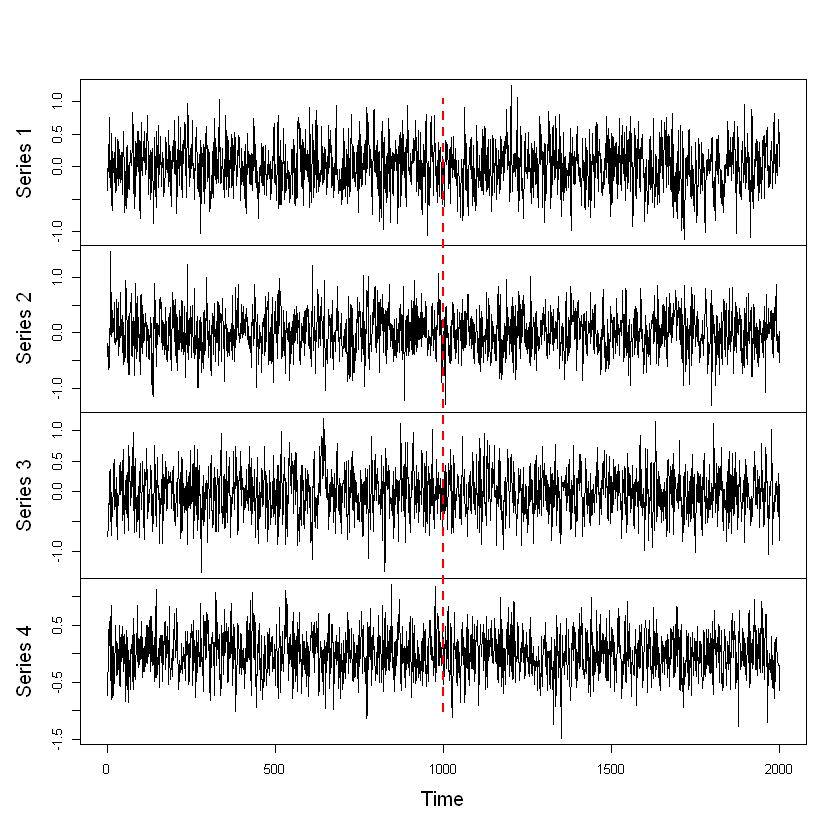

In [4]:
# simulate process; plot time series and breaks
x <- tv_MA(Theta, Sigma, 2000)
plot.ts(x, main = "")
abline(v = 1000, col = "red", lty = 2, lwd = 2)

Based on the estimated ACVF it would seem sensible to conclude that the four time series follow independent MA(1) processes, and naively clustering on the sample correlation identifies the wrong groups with coin-flip probability.

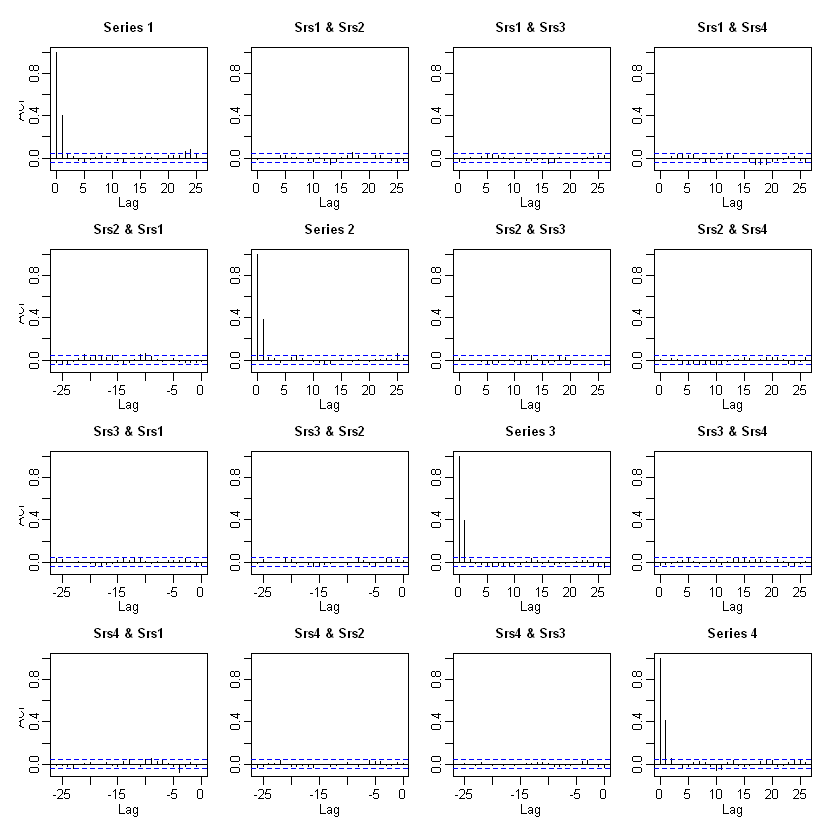

In [6]:
acf(x)

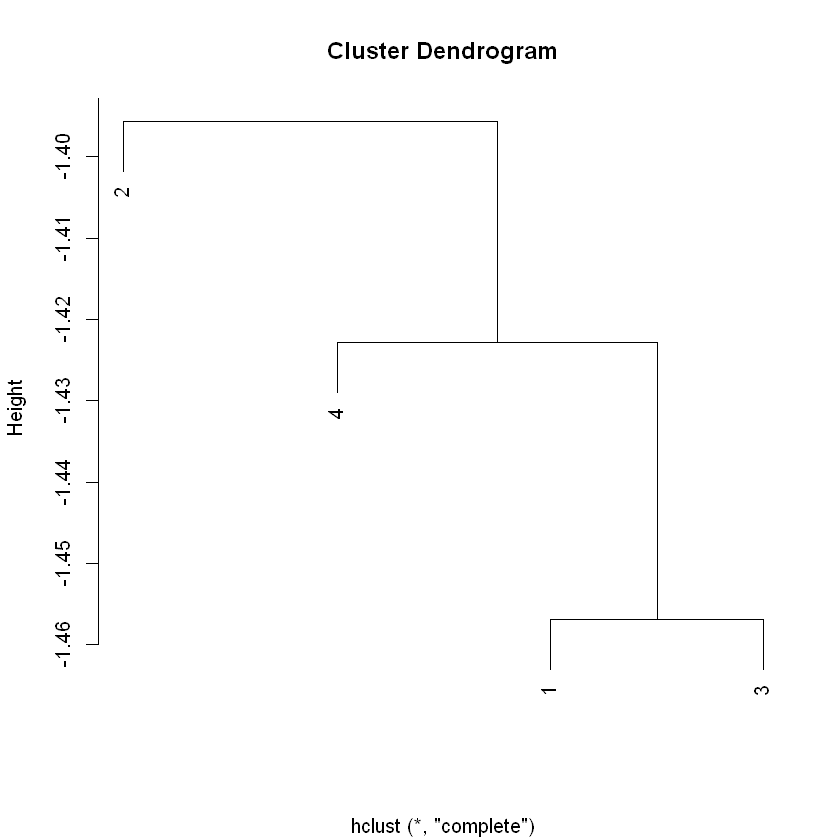

In [7]:
# clusering on the basis of sample correlation matrix
acf.lag0 <- dist(matrix(acf(x, lag.max = 0, plot = F)$acf,4))
hc <- hclust(-acf.lag0)
plot(hc, xlab = "")

Considering only time points before (or after) $t = 1000$ the group structure would have been clear. In fact, taking the absolute autocorrelations to avoid cancellation on $\left \{ 1,1000 \right \}$ and $\left \{ 1001,2000 \right \}$ and averaging the group structure would likewise have been clear. This motivates the technique discussed in the next chunk.

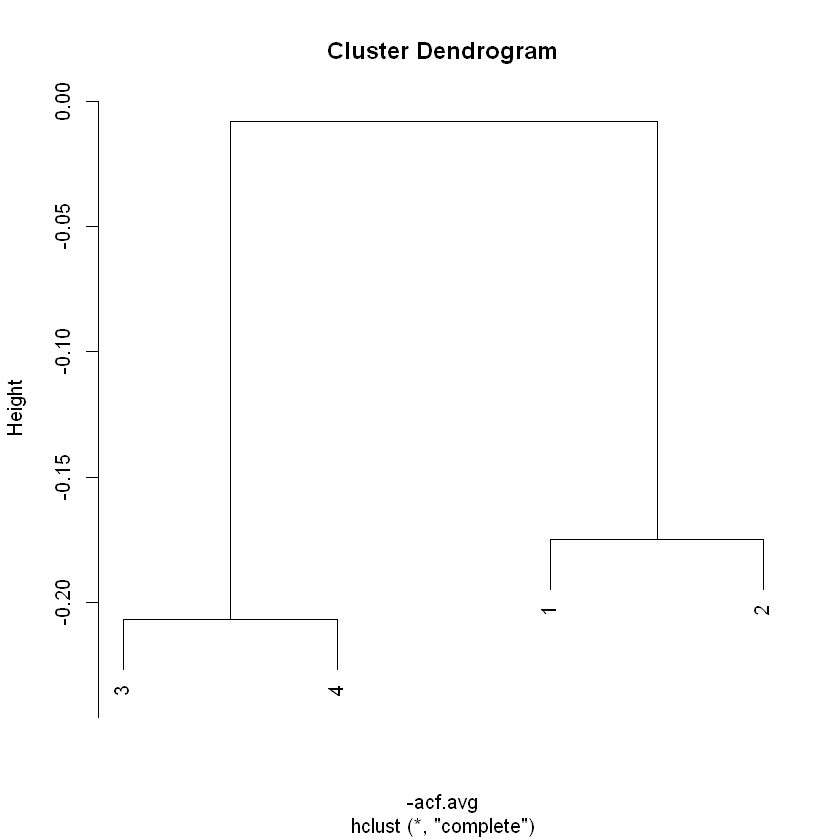

In [8]:
# averaging correlations pre and post changepoint
acf.pre <- matrix(acf(x[1:1000,], lag.max = 0, plot = F)$acf,4)
acf.post <- matrix(acf(x[1001:2000,], lag.max = 0, plot = F)$acf,4)
acf.avg <- as.dist(.5*abs(acf.pre) + .5*abs(acf.post))
# clusters based on average
hc <- hclust(-acf.avg)
plot(hc)

## Motivated technique

### Overview

Let $\theta_{X,Y}$ be the population counterpart of a similarity measure for two time series. Say we observe two univariate time series $\left \{ X_t, Y_t \right \}_{t=1}^T$, the idea is to estimate $\theta_{X,Y}$ on disjoint blocks whose length goes to infinity with the sample size. If a block's estimate of $\theta_{X,Y}$ disagrees significantly with one or both of its neighbors it is likely to contain a changepoint and so should be given less weight in the final estimate of $\theta_{X,Y}$.

Examples of settings this technique could handle include: (i) $\theta_{X,Y} = \theta_{X,Y}(t)$ is a piecewise constant function of time and we are interested in extracting some constant $\overline{\theta}_{X,Y}$ which summarises the time-varying measure, (ii) $\theta_{X,Y}$ is constant but the process $(X_t,Y_t)_{t \in \mathbb{Z}}$ includes piecewise constant nuisance terms which makes estimation difficult, and (iii) some combination of (i) and (ii). 

### Sketch of technical details

(*This section is necessarily loose since I have not been specific as to how $\theta(t)$ and $\overline{\theta}$ are related, however when $\theta(t)$ is constant we should have that $\theta = \overline{\theta}$.*)

Given a sample of size $T$ to compute an estimate of $\overline{\theta}$ I propose the following:

1. If initially the similarity measure was some $\phi(t)$ taking values outside of $[0,1]$ then set $\theta(t) = f(\phi(t))$ where $f: \text{support}(\phi) \rightarrow [0,1]$. 

2. On $[1,T]$ define disjoint blocks $\mathcal{B}_1,...,\mathcal{B}_{b}$ where $b \equiv b(T)$ and each block has length $l \equiv l(T)$ such that (i) $l \rightarrow \infty$ as $T \rightarrow \infty$, (ii) $T^{-1}l \rightarrow 0$ as $T \rightarrow \infty$, and (iii) $b\cdot l = T$ w.l.o.g. 
3. On each block $\left \{ \mathcal{B}_j \right \}_{j=1}^b$ estimate $\left \{ \widehat{\theta}_j \right \}_{j=1}^b$, the sample counterparts of $\overline{\theta}$ on $[(j-1)(l+1),jl]$
4. Assign non-negative weights $\omega_j = \omega_j(T)$ which satisfy (i) $\sum_{j=1}^b \omega_j = 1 $ and (ii) if $\underset{k \in \left \{ -1,1 \right \}}{\sup} \left | \widehat{\theta}_j - \widehat{\theta}_{j+k} \right | \not\rightarrow 0$ as $T \rightarrow \infty$ then $\omega_j \rightarrow 0$
5. Return $\widetilde{\theta} = \sum_{j=1}^b \omega_j \cdot \widehat{\theta}_j$ as the sample estimate of $\overline{\theta}$. 

### Some initial remarks

In **step 1** there may be a way of choosing the function $f$ which is somehow "optimal". For example since the end goal is to measure similarity using several measures, if an individual measure already has support $[0,1]$ it may still be advantageous to transform it in such a way that the new measure has uniform density over the interval.

In **step 2** it will be necessary to link assumptions on the number and distribution of changepoints to the block length $l$, in order to avoid a situation in which every block contains a changepoint. As with block bootstrap methods for stationary time series there will be an optimal block length which depends on $\theta$. It might be possible to avoid choosing the block length altogether by using random block lengths as in the stationary bootstrap.

Finally in **step 4** there may be some way of choosing weights which are "optimal", perhaps by taking into account the variance of $\widehat{\theta}_j$ on each block. 

## Examples

Here I illustrate the technique with some non-optimized parameters which however satisfy the conditions given above. Specifically the weights used are $\omega_j = \frac{k(j)}{\sum_i k(i)}$ with $k(j) = \min \left \{  \left | \widehat{\theta}_j - \widehat{\theta}_{j-1} + \epsilon \right |^{-2}, \left | \widehat{\theta}_j - \widehat{\theta}_{j+1} + \epsilon \right |^{-2} \right \}$ and $\epsilon = 1$, and the block length is set to $l = \text{floor}\left \{ T^{1/2} \right \}$. 

### tv-MA(1)

Following on from simulated example, clustering on correlations weighted according to block agreements reveals the correct grouping of similar time series. 

1.0000000,NA,NA,NA
0.1649149,1.0000000,NA,NA
0.1197587,0.1373866,1.0000000,NA
0.1104965,0.1217571,0.1814399,1


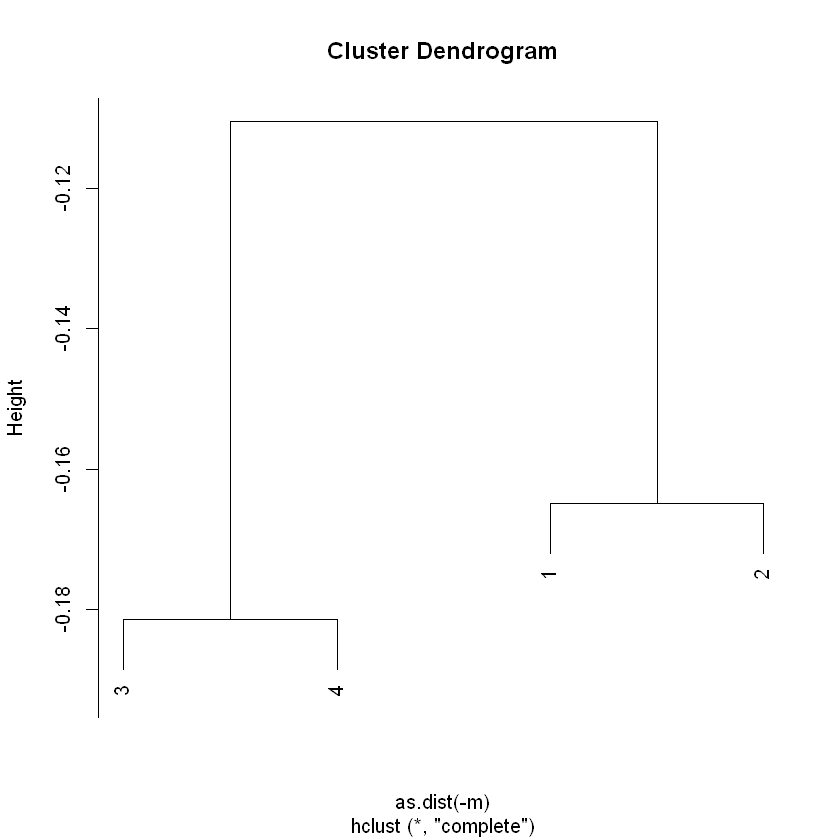

In [182]:
m <- matrix(,4,4)
for (i in 1:4){
    for (j in 1:i){
        m[i,j] <- kern(x[,i],x[,j],ff)
    }
}

m

hc <- hclust(as.dist(-m))
plot(hc)

### Piecewise constant means

The technique is also appropriate for estimating the long run variance of a time series in the presence of a piecewise-constant mean, i.e. $X_t = \mu(t) + \boldsymbol{\epsilon}_t$. In the example below $X_t \in \mathbb{R}^2$ and $\epsilon_t \sim \mathcal{N}(\boldsymbol{0}, \Sigma_\epsilon)$ with $\Sigma_\epsilon = \text{Toep}(1,0.5)$. 

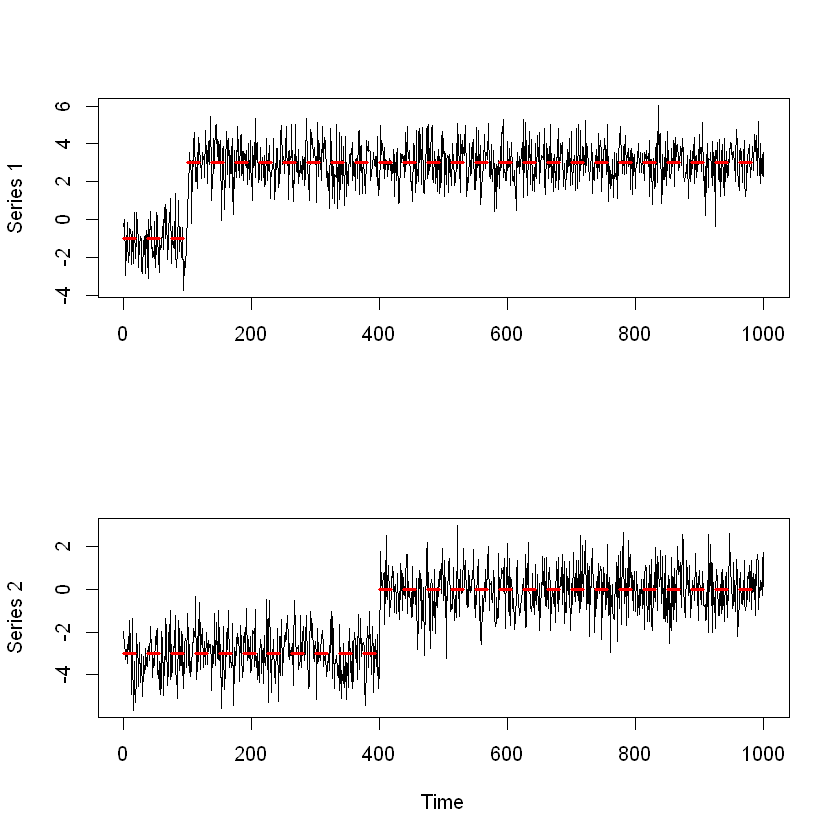

In [3]:
par(mfrow = c(2,1))

e <- rmvnorm(1000,c(0,0), toeplitz(c(1,0.5)))
mu <- cbind(c(rep(-1,100),rep(3,900)),c(rep(-3,400),rep(0,600)))
X <- mu + e 

x1 <- X[,1]
x2 <- X[,2]

plot.ts(X[,1], ylab = "Series 1", xlab = "")
segments(0,-1,100,-1, col = "red", lwd = 3, lty = 2)
segments(100,3,1000,3, col = "red", lwd = 3, lty = 2)

plot.ts(X[,2], ylab = "Series 2")
segments(0,-3,400,-3, col = "red", lwd = 3, lty = 2)
segments(400,0,1000,0, col = "red", lwd = 3, lty = 2)

In [15]:
cat("Sample covariance: ",cov(x1,x2),"\n")
cat("New technmique: ",kern(x1,x2,cov))

Sample covariance:  1.364292 
New technmique:  0.4107741

### Digression: comparison with median-based estimators

With piecewise constant means it is well known that median-based estimators are consistent for the long run variance. For example, in the simulation above an estimate for the variance of series 1 based on the median of the first differenced series, say $\widehat{\sigma}^2_{\text{MAD}}$ easily outperforms the new technique: 

$$\widehat{\sigma}^2_{\text{MAD}} = \frac{\text{med}(|X_1 - X_2|, ..., |X_{T-1} - X_T|)}{\Phi^{-1}(0.5)\sqrt{2}}$$

In [14]:
cat("MAD: ",median(abs(diff(x1)))/(qnorm(3/4)*sqrt(2)),"\n")
cat("New technique: ",kern(x1,x1,cov))

MAD:  1.006937 
New technique:  0.8859083

Nonetheless the new technique has two main advantages: (i) median-type estimators rely on a parametric model for the changepoints to define an appropriate transformation of the data, while the new technique relies only on disagreement between consistent estimators; and (ii) when the process is serially correlated median type estimators are in general inconsistent.

To illustrate (ii) consider $Z_t = \mu(t) + \epsilon_t$ with $Z_t \in \mathbb{R}$, $\epsilon_t$ follows an MA(1) process with parameter $\theta = 0.5$ and standard Gaussian innovations, and $\mu(t)$ having a single changepoint occurring uniformally on $[1,1000]$. The process up to $T = 1000$ is simulated $1000$ times below, and the long run variance is estimated. 

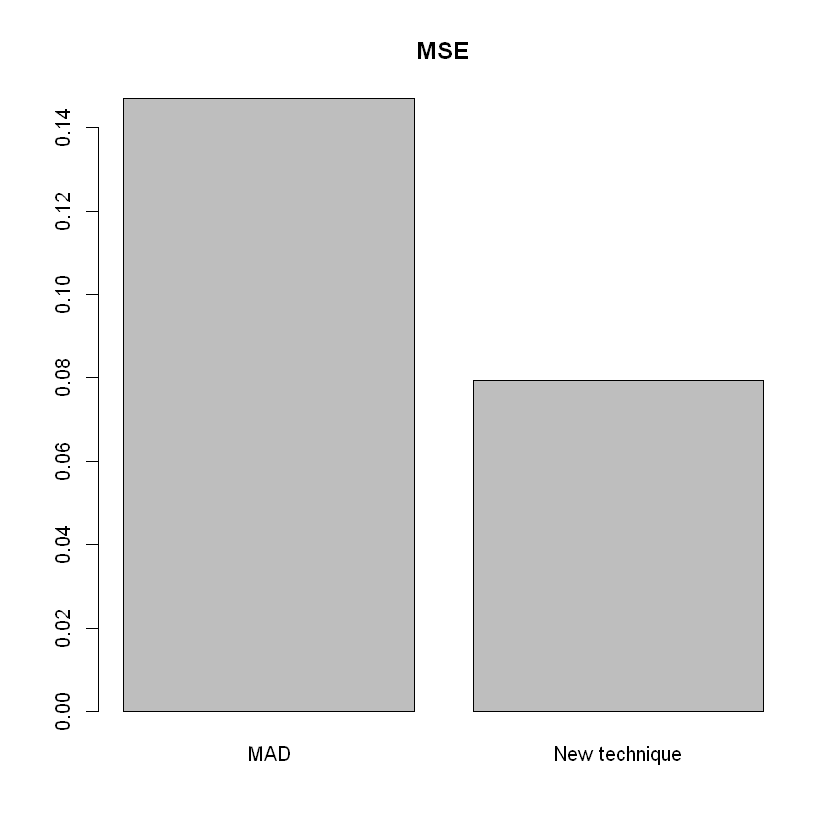

In [46]:
mad_est <- c()
kern_est <- c()
var_est <- c()

n = 1000
for (i in 1:n){
    tau <- sample(200:800,1)
    z <- arima.sim(model=list(ma=c(0.5)),n=1000) + c(rep(1,tau),rep(2,1000-tau))
    mad_est <- c(mad_est, median(abs(diff(z)))/(qnorm(3/4)*sqrt(2))-1.25)
    kern_est <- c(kern_est, kern(z,z,cov)-1.25)
}

barplot(c(sum(mad_est^2/n), sum(kern_est^2/n)), 
        main = "MSE", 
        names.arg = c("MAD","New technique"))